In [1]:
import torch
from torch import nn

In [40]:
import torch
import torch.nn as nn

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 假设我们有以下的配置
seq_length = 10  # 序列长度
batch_size = 2  # 批量大小
feature_size = 512  # 特征大小
num_heads = 8  # 注意力头数
num_encoder_layers = 3  # 编码器层数
num_decoder_layers = 3  # 解码器层数

# 创建位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# 创建 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.transformer = nn.Transformer(d_model=feature_size, nhead=num_heads,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          batch_first=True)
        self.pos_encoder = PositionalEncoding(feature_size)
        self.input_embedding = nn.Embedding(feature_size, feature_size)
        self.output_embedding = nn.Embedding(feature_size, feature_size)

    def forward(self, src, tgt):
        src = self.input_embedding(src) * torch.sqrt(torch.tensor(feature_size, dtype=torch.float))
        # tgt = self.output_embedding(tgt) * torch.sqrt(torch.tensor(feature_size, dtype=torch.float))
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        print("tgt")
        print(tgt)
        output = self.transformer(src, tgt)
        return output

# 实例化模型
model = TransformerModel().to(device)
model.eval()
# 创建一些随机数据作为输入和目标序列
src = torch.randint(0, feature_size, (batch_size, seq_length)).to(device)
tgt = torch.randint(0, feature_size, (batch_size, feature_size)).to(device)
tgt = tgt.unsqueeze(1).repeat(1, 60, 1)
print(tgt.shape)

# 正向传播
output = model(src, tgt)

# 查看输出形状
print(output.shape)  # 应该是 (batch_size, seq_length, feature_size)
print(output)

torch.Size([2, 60, 512])
tgt
tensor([[[382.0000, 127.0000,   2.0000,  ..., 334.0000,  35.0000,  48.0000],
         [382.0000, 127.0000,   2.0000,  ..., 334.0000,  35.0000,  48.0000],
         [382.0000, 127.0000,   2.0000,  ..., 334.0000,  35.0000,  48.0000],
         ...,
         [382.0000, 127.0000,   2.0000,  ..., 334.0000,  35.0000,  48.0000],
         [382.0000, 127.0000,   2.0000,  ..., 334.0000,  35.0000,  48.0000],
         [382.0000, 127.0000,   2.0000,  ..., 334.0000,  35.0000,  48.0000]],

        [[489.8415, 215.5403, 124.8219,  ..., 100.0000, 266.0001, 163.0000],
         [489.8415, 215.5403, 124.8219,  ..., 100.0000, 266.0001, 163.0000],
         [489.8415, 215.5403, 124.8219,  ..., 100.0000, 266.0001, 163.0000],
         ...,
         [489.8415, 215.5403, 124.8219,  ..., 100.0000, 266.0001, 163.0000],
         [489.8415, 215.5403, 124.8219,  ..., 100.0000, 266.0001, 163.0000],
         [489.8415, 215.5403, 124.8219,  ..., 100.0000, 266.0001, 163.0000]]],
       device='

In [108]:
import torch
import torch.nn.functional as F

# 假设video_embeddings和text_embeddings是模型输出的嵌入向量
# video_embeddings和text_embeddings的形状都是[batch_size, sequence_length, hidden_size]
# 例如：
video_embeddings = torch.randn(2, 20, 128)
text_embeddings = torch.randn(2, 20, 128)


def split_feature(video_embeddings,text_embeddings):
    # 计算余弦相似度
    cosine_similarities = F.cosine_similarity(video_embeddings, text_embeddings, dim=2)
    # 设置一个相似度阈值
    similarity_threshold = 0.1

    # 初始化列表来存储不同的信息
    multimodal_mutual_info = []
    video_only_info = []
    text_only_info = []

    for batch_idx in range(cosine_similarities.shape[0]):
        # 获取当前batch的相似度，并排序
        similarities_sorted, indices = torch.sort(cosine_similarities[batch_idx], descending=True)
        
        # 找到相似度的50%百分位数
        threshold_index = 20 // 2
        similarity_threshold = similarities_sorted[threshold_index]

        multimodal_mutual_info_b = []
        video_only_info_b = []
        text_only_info_b = []

        for seq_idx in range(20):
            if cosine_similarities[batch_idx, seq_idx] >= similarity_threshold:
                # 如果相似度在前50%，则添加到多模态共有信息中
                multimodal_mutual_info_b.append(text_embeddings[batch_idx, seq_idx])
                multimodal_mutual_info_b.append(video_embeddings[batch_idx, seq_idx])
                
                
            else:
                # 否则，分别添加到模态独有信息中
                video_only_info_b.append(video_embeddings[batch_idx, seq_idx])
                text_only_info_b.append(text_embeddings[batch_idx, seq_idx])

        # 将每个batch的列表转换为Tensor
        if multimodal_mutual_info_b:
            multimodal_mutual_info.append(torch.stack(multimodal_mutual_info_b))
        if video_only_info_b:
            video_only_info.append(torch.stack(video_only_info_b))
        if text_only_info_b:
            text_only_info.append(torch.stack(text_only_info_b))

        
    # 转换为Tensor
    multimodal_mutual_info = torch.stack(multimodal_mutual_info)
    video_only_info = torch.stack(video_only_info)
    text_only_info = torch.stack(text_only_info)

    return multimodal_mutual_info,video_only_info,text_only_info


In [109]:
multimodal_mutual_info,video_only_info,text_only_info=split_feature(video_embeddings,text_embeddings)

tensor([ 0.1599,  0.0911,  0.0881,  0.0666,  0.0651,  0.0609,  0.0599,  0.0574,
         0.0228,  0.0128,  0.0053,  0.0050, -0.0145, -0.0796, -0.0903, -0.0938,
        -0.1380, -0.1483, -0.1800, -0.2523])
tensor(0.0053)
tensor(0.0574)
tensor(0.0881)
tensor(0.0651)
tensor(0.1599)
tensor(0.0609)
tensor(0.0599)
tensor(0.0666)
tensor(0.0128)
tensor(0.0911)
tensor(0.0228)
tensor([ 0.3368,  0.1608,  0.1055,  0.0675,  0.0619,  0.0532,  0.0456,  0.0363,
         0.0218,  0.0098, -0.0654, -0.0661, -0.0761, -0.0821, -0.0839, -0.0967,
        -0.0999, -0.1007, -0.1070, -0.1594])
tensor(0.0098)
tensor(0.3368)
tensor(0.0218)
tensor(0.1055)
tensor(0.1608)
tensor(0.0456)
tensor(0.0619)
tensor(-0.0654)
tensor(0.0675)
tensor(0.0363)
tensor(0.0532)


In [94]:
multimodal_mutual_info.shape

torch.Size([2, 22, 128])

In [95]:
video_only_info.shape

torch.Size([2, 9, 128])

In [126]:
import torch
import torch.nn.functional as F

# 假设video_embeddings和text_embeddings是模型输出的嵌入向量
# video_embeddings和text_embeddings的形状都是[batch_size, sequence_length, hidden_size]
# 例如：
video_embeddings = torch.randn(2, 20, 128)
text_embeddings = torch.randn(2, 20, 128)


def split_feature(video_embeddings,text_embeddings):
    # 计算余弦相似度
    # cosine_similarities = F.cosine_similarity(video_embeddings, text_embeddings, dim=2)
    v_b,v_l,v_h=video_embeddings.shape
    t_b,t_l,t_h=text_embeddings.shape

    for batch_idx in range(v_b):
        for vl in range(v_l):
            for tl in range(t_l):
                 cos_sim=F.cosine_similarity(video_embeddings[batch_idx][vl],text_embeddings[batch_idx][tl],dim=0)
                 print(cos_sim)





In [127]:
split_feature(video_embeddings,text_embeddings)

tensor(0.1622)
tensor(-0.0991)
tensor(-0.0698)
tensor(0.0512)
tensor(0.0878)
tensor(0.1146)
tensor(0.0349)
tensor(0.0283)
tensor(-0.1266)
tensor(0.0001)
tensor(0.0131)
tensor(0.0625)
tensor(-0.0445)
tensor(0.0094)
tensor(0.1458)
tensor(-0.1665)
tensor(0.1233)
tensor(-0.1115)
tensor(0.0877)
tensor(0.0808)
tensor(-0.0807)
tensor(0.0544)
tensor(0.1224)
tensor(-0.0206)
tensor(0.0547)
tensor(-0.0203)
tensor(-0.1266)
tensor(-0.0137)
tensor(-0.1390)
tensor(-0.0266)
tensor(-0.1563)
tensor(-0.1560)
tensor(0.1491)
tensor(-0.0549)
tensor(0.1059)
tensor(0.0905)
tensor(-0.1631)
tensor(0.1543)
tensor(-0.0233)
tensor(0.0541)
tensor(0.0606)
tensor(0.0038)
tensor(-0.0537)
tensor(0.2433)
tensor(-0.0860)
tensor(0.0205)
tensor(0.0629)
tensor(0.0095)
tensor(0.1351)
tensor(-0.0441)
tensor(0.0152)
tensor(-0.0495)
tensor(-0.0188)
tensor(-0.0368)
tensor(-0.0115)
tensor(0.0271)
tensor(-0.0247)
tensor(-0.0324)
tensor(0.0464)
tensor(-0.0895)
tensor(0.0607)
tensor(0.0108)
tensor(0.0306)
tensor(-0.0318)
tensor(-0.1

In [240]:
import torch
import torch.nn.functional as F
sequence_length = 3  # 序列长度
batch_size = 2  # 批量大小
hidden_size = 5  # 特征大小
def split_feature(video_embeddings, text_embeddings):
    # 确保视频和文本嵌入的batch size是相同的
    assert video_embeddings.size(0) == text_embeddings.size(0)
    
    # 获取嵌入维度
    v_b, v_l, v_h = video_embeddings.shape
    t_b, t_l, t_h = text_embeddings.shape
    assert v_h == t_h  # 确保视频和文本嵌入在特征维度上是相同的

    # 初始化列表来存储共有信息和各自模态的独有信息
    multimodal_mutual_info = []
    video_only_info = []
    text_only_info = []

    # 对每个batch进行处理
    for batch_idx in range(v_b):
        # 计算当前batch中所有特征对的相似度
        similarities = torch.zeros((v_l, t_l))
        for vl in range(v_l):
            for tl in range(t_l):
                # 计算视频特征和文本特征之间的余弦相似度
                cos_sim = F.cosine_similarity(video_embeddings[batch_idx][vl].unsqueeze(0), text_embeddings[batch_idx][tl].unsqueeze(0))
                similarities[vl, tl] = cos_sim

        # 将相似度矩阵转换为一维数组并排序，选择相似度最高的50%
        flat_similarities = similarities.view(-1)
        sorted_similarities, sorted_indices = torch.sort(flat_similarities, descending=True)
        top_half_indices = sorted_indices[:len(sorted_indices) // 2]



        # 选取前50%的相似度对应的特征
        selected_video_indices = top_half_indices // t_l
        selected_text_indices = top_half_indices % t_l


        selected_video_indices=torch.unique_consecutive(selected_video_indices)[:vl//2]

        selected_text_indices=torch.unique_consecutive(selected_text_indices)[:tl//2]

        # 标记所有特征是否已选为共有特征
        selected_for_mutual_info = torch.zeros_like(similarities, dtype=torch.bool)

        # 标记选为共有特征的位置
        selected_for_mutual_info[selected_video_indices, selected_text_indices] = True

        # 根据标记将特征分配到对应列表
        for vl in range(v_l):
            for tl in range(t_l):
                if selected_for_mutual_info[vl, tl]:
                    # 如果是共有特征
                    multimodal_mutual_info.append(video_embeddings[batch_idx, vl])
                    multimodal_mutual_info.append(text_embeddings[batch_idx, tl])
                else:
                    # 分别添加到各自模态的独有信息中
                    video_only_info.append(video_embeddings[batch_idx, vl])
                    text_only_info.append(text_embeddings[batch_idx, tl])

        for vi in range(v_l):
            if vi in selected_video_indices:
                multimodal_mutual_info.append(video_embeddings[batch_idx, vi])
            else:
                video_only_info.append(video_embeddings[batch_idx, vi])
        for ti in range(t_l):
            if ti in selected_text_indices:
                multimodal_mutual_info.append(text_embeddings[batch_idx, ti])
            else:
                text_only_info.append(text_embeddings[batch_idx, ti])


    # 转换列表为Tensor
    if multimodal_mutual_info:
        multimodal_mutual_info = torch.stack(multimodal_mutual_info)
    if video_only_info:
        video_only_info = torch.stack(video_only_info)
    if text_only_info:
        text_only_info = torch.stack(text_only_info)
    
    return multimodal_mutual_info, video_only_info, text_only_info

# 假设的视频和文本嵌入向量
video_embeddings = torch.randn(batch_size, sequence_length, hidden_size)
text_embeddings = torch.randn(batch_size, sequence_length, hidden_size)

# 调用函数
multimodal_mutual_info, video_only_info, text_only_info = split_feature(video_embeddings, text_embeddings)

# 检查结果
print(multimodal_mutual_info.shape)
print(video_only_info.shape)
print(text_only_info.shape)


torch.Size([8, 5])
torch.Size([20, 5])
torch.Size([20, 5])


In [159]:
for i in multimodal_mutual_info:
    print(i)

tensor([ 2.4921, -1.7299, -3.6645, -0.1130,  0.1598, -0.1183,  0.1616,  1.1894,
         1.0763,  1.3261,  0.0129,  0.5039])
tensor([ 1.0351,  0.3673,  0.0557, -0.8657, -1.0000, -0.8180, -0.3943, -1.0877,
         0.4152, -1.1640, -1.2055,  0.9571])
tensor([ 2.4921, -1.7299, -3.6645, -0.1130,  0.1598, -0.1183,  0.1616,  1.1894,
         1.0763,  1.3261,  0.0129,  0.5039])
tensor([-0.4894, -0.0323, -0.6528,  0.9902, -2.2690,  0.1405,  1.7084, -0.6363,
         0.1503, -0.7970, -1.4187,  0.8197])
tensor([ 2.4921, -1.7299, -3.6645, -0.1130,  0.1598, -0.1183,  0.1616,  1.1894,
         1.0763,  1.3261,  0.0129,  0.5039])
tensor([ 0.4048,  0.4500,  0.0289,  0.9127, -0.7483,  1.5466,  3.2040,  1.5057,
        -0.4348, -0.0674, -0.3573, -1.6098])
tensor([ 0.8275, -1.1033, -0.7473, -1.4598, -0.6643, -0.1592, -0.0334,  1.6658,
         0.0148,  1.0321,  0.1353, -0.4821])
tensor([ 0.7179,  1.0248,  0.9483, -1.3332, -0.7922,  0.3112,  1.2247,  0.1719,
        -1.2398,  1.1800, -1.6752,  0.2876])


In [14]:
import torch
import torch.nn.functional as F
sequence_length = 60  # 序列长度
batch_size = 2  # 批量大小
hidden_size = 512  # 特征大小
def split_feature(video_embeddings, text_embeddings, batch_size, hidden_size):
    # 确保视频和文本嵌入的batch size是相同的
    assert video_embeddings.size(0) == text_embeddings.size(0)
    
    # 获取嵌入维度
    v_b, v_l, v_h = video_embeddings.shape
    t_b, t_l, t_h = text_embeddings.shape
    assert v_h == t_h  # 确保视频和文本嵌入在特征维度上是相同的

    # 初始化列表来存储共有信息和各自模态的独有信息

    video_mutual_info = [[] for i in range(batch_size)]
    text_mutual_info = [[] for i in range(batch_size)]
    video_only_info = [[] for i in range(batch_size)]
    text_only_info = [[] for i in range(batch_size)]

    # 对每个batch进行处理
    for batch_idx in range(v_b):
        # 计算当前batch中所有特征对的相似度
        similarities = torch.zeros((v_l, t_l))
        for vl in range(v_l):
            for tl in range(t_l):
                # 计算视频特征和文本特征之间的余弦相似度
                cos_sim = F.cosine_similarity(video_embeddings[batch_idx][vl].unsqueeze(0), text_embeddings[batch_idx][tl].unsqueeze(0))
                similarities[vl, tl] = cos_sim

        # 将相似度矩阵转换为一维数组并排序，选择相似度最高的50%
        flat_similarities = similarities.view(-1)
        sorted_similarities, sorted_indices = torch.sort(flat_similarities, descending=True)
        top_half_indices = sorted_indices[:len(sorted_indices) // 2]



        # 选取前50%的相似度对应的特征
        selected_video_indices = top_half_indices // t_l
        selected_text_indices = top_half_indices % t_l


        selected_video_indices=torch.unique(selected_video_indices,sorted=False)[:vl//2]

        selected_text_indices=torch.unique(selected_text_indices,sorted=False)[:tl//2]
        print(selected_text_indices)
        print(selected_video_indices)

        for vi in range(v_l):
            if vi in selected_video_indices:
                video_mutual_info[batch_idx].append(video_embeddings[batch_idx, vi])
            else:
                video_only_info[batch_idx].append(video_embeddings[batch_idx, vi])


        count=0
        for ti in range(t_l):
            if ti in selected_text_indices:
                # print(ti)
                count+=1
                text_mutual_info[batch_idx].append(text_embeddings[batch_idx, ti])

            else:
                text_only_info[batch_idx].append(text_embeddings[batch_idx, ti])
        print(count)
        print(selected_text_indices)

        
    max_length = max(len(sublist) for sublist in video_mutual_info)
    for batch_id in range(batch_size):
        if len(video_mutual_info[batch_id])<max_length:
            for i in range(len(video_mutual_info[batch_id]),max_length):
                video_mutual_info[batch_id].append(torch.zeros([hidden_size]))

    max_length = max(len(sublist) for sublist in text_mutual_info)
    for batch_id in range(batch_size):
        if len(text_mutual_info[batch_id])<max_length:
            for i in range(len(text_mutual_info[batch_id]),max_length):
                text_mutual_info[batch_id].append(torch.zeros([hidden_size]))

    max_length = max(len(sublist) for sublist in text_only_info)
    for batch_id in range(batch_size):
        if len(text_only_info[batch_id])<max_length:
            for i in range(len(text_only_info[batch_id]),max_length):
                text_only_info[batch_id].append(torch.zeros([hidden_size]))

        
    max_length = max(len(sublist) for sublist in video_only_info)
    for batch_id in range(batch_size):
        if len(video_only_info[batch_id])<max_length:
            for i in range(len(video_only_info[batch_id]),max_length):
                video_only_info[batch_id].append(torch.zeros([hidden_size]))

    video_mutual_info = torch.stack([torch.stack(sublist) for sublist in video_mutual_info])
    text_mutual_info = torch.stack([torch.stack(sublist) for sublist in text_mutual_info])
    text_only_info = torch.stack([torch.stack(sublist) for sublist in text_only_info])
    video_only_info = torch.stack([torch.stack(sublist) for sublist in video_only_info])


    return video_mutual_info, text_mutual_info, video_only_info, text_only_info

# 假设的视频和文本嵌入向量
video_embeddings = torch.randn(batch_size, sequence_length, hidden_size)
text_embeddings = torch.randn(batch_size, sequence_length, hidden_size)

# 调用函数
video_mutual_info, text_mutual_info, video_only_info, text_only_info = split_feature(video_embeddings, text_embeddings,batch_size, hidden_size)

# 检查结果
print(video_mutual_info.shape)
print(text_mutual_info.shape)
print(video_only_info.shape)
print(text_only_info.shape)


tensor([ 5,  2, 15, 23, 54,  6, 51, 25, 58, 13, 43, 16, 45,  1, 42, 37, 52, 33,
        49, 59, 50, 36, 11,  8, 29,  4, 27, 35, 32])
tensor([40, 14, 15, 37, 45, 11, 43,  2, 41, 50,  5,  1, 58, 52, 22,  4,  6, 21,
        36,  7, 38, 32, 47,  9, 18, 26,  3, 53, 49])
29
tensor([ 5,  2, 15, 23, 54,  6, 51, 25, 58, 13, 43, 16, 45,  1, 42, 37, 52, 33,
        49, 59, 50, 36, 11,  8, 29,  4, 27, 35, 32])
tensor([18, 27, 21, 31,  7, 56, 24, 25, 15, 17, 52, 50, 45,  9,  0, 42, 47, 11,
        34, 26, 32, 54, 35, 30, 58, 48, 10, 19, 13])
tensor([28, 15, 19,  3, 59, 54, 32, 53, 52, 51, 13, 47,  9, 17, 33, 49, 41, 38,
        44,  1, 16, 45,  2,  4, 56,  6, 58, 26, 14])
29
tensor([18, 27, 21, 31,  7, 56, 24, 25, 15, 17, 52, 50, 45,  9,  0, 42, 47, 11,
        34, 26, 32, 54, 35, 30, 58, 48, 10, 19, 13])
torch.Size([2, 29, 512])
torch.Size([2, 29, 512])
torch.Size([2, 31, 512])
torch.Size([2, 31, 512])


In [16]:
multimodal_mutual_info = torch.cat((video_mutual_info, text_mutual_info),dim=1)
print(multimodal_mutual_info.shape)
multimodal_mutual_info=torch.mean(multimodal_mutual_info,dim=1)
print(multimodal_mutual_info.shape)
mutual_info_expanded = multimodal_mutual_info.unsqueeze(1).expand(-1, video_only_info.size(1), -1)
print(mutual_info_expanded.shape)       
video_only_info_gate=torch.cat((video_only_info,mutual_info_expanded),dim=2)
print(video_only_info_gate.shape)       

torch.Size([2, 58, 512])
torch.Size([2, 512])
torch.Size([2, 31, 512])
torch.Size([2, 31, 1024])


In [258]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GateControlledModel(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(GateControlledModel, self).__init__()
        # 定义一个线性层
        self.linear = nn.Linear(hidden_size * 2, output_size)  # *2因为我们将连接两个隐藏层

    def forward(self, video_info, mutual_info):
        # video_info形状: [batch_size, sequence_length, hidden_size]
        # mutual_info形状: [batch_size, hidden_size]
        
        # 将mutual_info扩展到与video_info的序列长度相匹配
        mutual_info_expanded = mutual_info.unsqueeze(1).expand(-1, video_info.size(1), -1)
        
        # 将mutual_info和video_info在最后一个维度上连接
        combined = torch.cat((video_info, mutual_info_expanded), dim=2)
        
        # 通过线性层
        gate_signals = self.linear(combined)
        
        # 应用sigmoid激活函数以获取门控信号
        gate_signals = torch.sigmoid(gate_signals)
        
        # 将门控信号应用到video_info上
        controlled_video_info = video_info * gate_signals
        
        return controlled_video_info

# 假设隐藏层大小和输出大小
hidden_size = 128
output_size = 128  # 输出的每个维度都需要一个门控信号

# 创建模型实例
model = GateControlledModel(hidden_size, output_size)

# 假设的输入数据
batch_size = 2
sequence_length = 10
video_info = torch.randn(batch_size, sequence_length, hidden_size)
mutual_info = torch.randn(batch_size, hidden_size)

# 调用模型
controlled_video_output = model(video_info, mutual_info)

print("受控制的视频信息形状:", controlled_video_output.shape)


受控制的视频信息形状: torch.Size([2, 10, 128])


In [7]:
import torch
video_info = torch.randn(2, 5, 8)
text_info = torch.randn(2, 5,8)
# 假设 v2t_attn 和 t2v_attn 已经定义并且它们的形状都是 [2, 60, 512]
# 首先计算两个张量的平均值
print("video_info",video_info[0][0])
print("text_info",text_info[0][0])
average_tensor = (video_info + text_info) / 2
print("average_tensor",average_tensor[0][0])

# # 接下来，如果需要在512维度上求均值，使用 torch.mean 并指定 dim=2
# mean_along_512 = torch.mean(average_tensor, dim=2)

# # mean_along_512 的形状现在是 [2, 60]，因为我们在每个 [2, 60, 512] 的张量上沿着最后一个维度求了均值
# print(mean_along_512.shape)  # 应该打印出 [2, 60]


video_info tensor([-0.4900, -0.5619, -1.1948,  0.6116,  0.3057,  0.6802, -2.3112,  1.4524])
text_info tensor([ 1.3749,  0.7404, -0.4067,  0.5937,  0.7644, -0.2825,  0.1739,  0.2631])
average_tensor tensor([ 0.4424,  0.0892, -0.8007,  0.6026,  0.5350,  0.1988, -1.0686,  0.8577])


In [20]:
import pickle as pkl
video_info = torch.randn(2, 512)
with open("kmeans_model_100.pkl", "rb") as f:
    k_means =  pkl.load(f)
topic = k_means.transform(video_info.detach().cpu().numpy())
print(topic.shape)

(2, 100)


d:\Anaconda\envs\assignment2\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
import torch

def gumbel_softmax(logits, temperature, k, eps=1e-10):
    gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) + eps) + eps)
    logits_with_noise = logits + gumbel_noise
    softmax = torch.softmax(logits_with_noise / temperature, dim=-1)
    values, indices = torch.topk(softmax, k, dim=1)
    return values, indices

# 示例：用随机数据测试 Gumbel-Top-k
logits = torch.randn(2, 60,512)  # 假设有10个patches的logits
temperature = 0.5  # 温度参数控制软化程度
k = 3  # 选择Top-3的元素

values, indices = gumbel_softmax(logits, temperature, k)
print("Selected values:", values.shape)
print("Selected indices:", indices.shape)


Selected values: torch.Size([2, 3, 512])
Selected indices: torch.Size([2, 3, 512])


In [31]:
print(indices.size(1))

3


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, text_features, image_features):
        # 计算文本特征和图像特征之间的相似度
        print(text_features.unsqueeze(1).shape)
        print(image_features.unsqueeze(0).shape)
        similarities = F.cosine_similarity(text_features.unsqueeze(1), image_features.unsqueeze(0), dim=2)
        print(similarities)
        
        # 对角线元素是正样本对的相似度
        positive_similarities = similarities.diag()

        # 计算每个正样本对与所有负样本对的损失
        loss = 0
        for i in range(len(text_features)):
            # 获取除了当前正样本对之外的所有负样本对相似度
            negative_similarities = torch.cat([similarities[i, :i], similarities[i, i+1:]])
            
            # 对于每一个负样本对，计算损失
            loss += F.relu(self.margin - positive_similarities[i] + negative_similarities).mean()

        return loss / len(text_features)

# 假设特征维度为 128
text_features = torch.randn(3, 128)  # 10 个文本特征
image_features = torch.randn(3, 128) # 10 个对应的图像特征

# 实例化损失函数
contrastive_loss = ContrastiveLoss(margin=0.5)

# 计算损失
loss = contrastive_loss(text_features, image_features)

print("Contrastive Loss:", loss.item())


torch.Size([3, 1, 128])
torch.Size([1, 3, 128])
tensor([[-0.0055,  0.1026,  0.0889],
        [ 0.1055, -0.0059, -0.0020],
        [-0.1103, -0.1274, -0.0508]])
Contrastive Loss: 0.5302807688713074


In [63]:
import torch

def sparse_ot(weights1, weights2, M):
    """Compute Wasserstein distances for one-dimensional weight vectors using PyTorch."""
    # 确保所有张量都在相同的设备上
    device = weights1.device
    weights2 = weights2.to(device)
    M = M.to(device)
    weights1 = F.softplus(weights1)
    weights2 = F.softplus(weights2)
    # 归一化权重
    weights1 = (weights1 + 1e-8) / weights1.sum()
    weights2 = (weights2 + 1e-8) / weights2.sum()

    # 找到非零元素的索引
    active1 = weights1.nonzero(as_tuple=False).squeeze()
    active2 = weights2.nonzero(as_tuple=False).squeeze()

    # 选择激活的权重和成本矩阵
    weights_1_active = weights1[active1]
    weights_2_active = weights2[active2]
    M_reduced = M[active1][:, active2]

    # 计算 Wasserstein 距离
    dist = sinkhorn_distance(weights_1_active, weights_2_active, M_reduced)

    return dist

def sinkhorn_distance(weights1, weights2, M, epsilon=0.01, max_iter=100):
    """简化的 Sinkhorn 算法实现."""
    K = torch.exp(-M / epsilon)
    u = torch.ones_like(weights1) / weights1.size(0)
    for _ in range(max_iter):
        u = weights1 / torch.mv(K, weights2 / torch.mv(K.t(), u))
    v = weights2 / torch.mv(K.t(), u)
    return torch.sum(u * torch.mv(K * M, v))

# def sinkhorn_distance(weights1, weights2, M, epsilon=0.01, max_iter=100):
#     """使用 log-sum-exp 技巧改进的 Sinkhorn 算法实现."""
#     log_weights1 = torch.log(weights1 + 1e-8)
#     log_weights2 = torch.log(weights2 + 1e-8)

#     # 计算 cost 矩阵的负指数除以 epsilon
#     K = torch.exp(-M / epsilon)
#     log_K = torch.log(K + 1e-8)

#     u = torch.zeros_like(weights1)
#     v = torch.zeros_like(weights2)

#     for _ in range(max_iter):
#         u = log_weights1 - torch.logsumexp(log_K + v.unsqueeze(0), dim=1)
#         v = log_weights2 - torch.logsumexp(log_K.t() + u.unsqueeze(0), dim=1)

#     dist = torch.sum(torch.exp(u + v) * M)
#     return dist




# Example usage:
weights1 = torch.randn(512, device='cuda')

weights2 = torch.randn(512, device='cuda')
M = torch.ones(512, 512) - torch.eye(512)
distances = sparse_ot(weights1, weights2, M)
print(distances)

tensor(0.3119, device='cuda:0')


In [64]:
print(distances)

tensor(0.3119, device='cuda:0')


In [ ]:
import torch

def sinkhorn_distance(weights1, weights2, M, epsilon=0.01, max_iter=100):
    """使用 Sinkhorn 算法计算两个权重向量之间的 Wasserstein 距离."""
    # 归一化权重以避免数值问题
    weights1 = (weights1 + 1e-8) / weights1.sum()
    weights2 = (weights2 + 1e-8) / weights2.sum()

    # 确定激活的权重，避免无效计算
    active1 = weights1.nonzero(as_tuple=False).squeeze()
    active2 = weights2.nonzero(as_tuple=False).squeeze()

    # 只对非零元素进行操作
    weights_1_active = weights1[active1]
    weights_2_active = weights2[active2]
    M_reduced = M[active1][:, active2]

    # 使用 log-sum-exp 技巧增强数值稳定性
    log_weights1 = torch.log(weights_1_active)
    log_weights2 = torch.log(weights_2_active)
    K = torch.exp(-M_reduced / epsilon)
    log_K = torch.log(K + 1e-8)

    u = torch.zeros_like(weights_1_active)
    v = torch.zeros_like(weights_2_active)

    for _ in range(max_iter):
        u = log_weights1 - torch.logsumexp(log_K + v.unsqueeze(0), dim=1)
        v = log_weights2 - torch.logsumexp(log_K.t() + u.unsqueeze(0), dim=1)

    dist = torch.sum(torch.exp(u + v) * M_reduced)
    return dist

# 示例使用：
weights1 = torch.rand(512,)
weights2 = torch.rand(512)
M = torch.ones(512, 512) - torch.eye(512)

distance = sinkhorn_distance(weights1, weights2, M)
print(distance)


tensor(341.9043)


In [83]:
weights2 = torch.rand(2,30,512)
print(torch.std(weights2, dim=1))
weights2 = torch.mean(weights2,dim=1)
print(weights2)

tensor([[0.2883, 0.2273, 0.2274,  ..., 0.3039, 0.2610, 0.3234],
        [0.2725, 0.2882, 0.2596,  ..., 0.2329, 0.2749, 0.2915]])
tensor([[0.4182, 0.6278, 0.3556,  ..., 0.4370, 0.5153, 0.4734],
        [0.5615, 0.5660, 0.4172,  ..., 0.4120, 0.4559, 0.4857]])


In [94]:
import torch
import torch.nn as nn

# 假设的词汇表大小
vocab_size = 5  # 包括<pad>, <sos>, <eos>, hello, world

# 真实摘要
summaries = torch.tensor([[1, 3, 2], [1, 4, 2]])  # <sos>, hello, <eos>

# 模型输出（假设的概率分布，通常由模型根据输入文本计算得出）
# 这里我们随机生成一些概率分布作为演示
outputs = torch.rand(2, 3, vocab_size)  # 3个时间步，每个时间步有一个概率分布


In [95]:
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 计算损失
loss = criterion(outputs, summaries)
print("Loss:", loss.item())


RuntimeError: Expected target size [2, 5], got [2, 3]

In [98]:
torch.stack([torch.empty(0),torch.empty(0)])

tensor([], size=(2, 0))

In [104]:
torch.zeros(512).unsqueeze(0).shape

torch.Size([1, 512])

In [105]:
import os
import json

def calculate_average_length(directory):
    total_length = 0
    file_count = 0

    # 遍历目录下的所有文件
    for filename in os.listdir(directory):
        if filename.endswith(".json"):  # 确保处理的是json文件
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                # 提取description字段的内容
                if 'description' in data:
                    description = data['description']
                    total_length += len(description)  # 累加description的长度
                    file_count += 1  # 文件计数

    # 计算平均长度
    if file_count > 0:
        average_length = total_length / file_count
        return average_length
    else:
        return 0  # 如果没有适当的json文件或字段，返回0

# 使用函数
directory = 'test'  # 替换为你的json文件目录
average_length = calculate_average_length(directory)
print(f"平均长度为: {average_length}")


平均长度为: 497.7626459143969


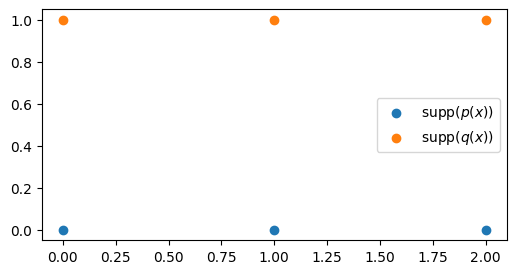

In [30]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

n_points = 3
a = np.array([[i, 0] for i in range(n_points)])
b = np.array([[i, 1] for i in range(n_points)])

plt.figure(figsize=(6, 3))
plt.scatter(a[:, 0], a[:, 1], label='supp($p(x)$)')
plt.scatter(b[:, 0], b[:, 1], label='supp($q(x)$)')
plt.legend();

In [65]:
import torch
from layers import SinkhornDistance

x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

Sinkhorn distance: 1.000


In [66]:
print(x.shape)

torch.Size([3, 2])


In [67]:
import torch
from layers import SinkhornDistance

x = torch.rand(512, requires_grad=True)
y = torch.rand(512, requires_grad=True)

x=x.reshape(2,256).to('cuda')
y=y.reshape(2,256).to('cuda')


sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None).to('cuda')

dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))
dist.backward()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [18]:
import torch
from layers import SinkhornDistance

x = torch.rand(512, requires_grad=True)
y = torch.rand(512, requires_grad=True)

x=x.reshape(2,256).to('cuda')
y=y.reshape(2,256).to('cuda')


sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None).to('cuda')

dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))
# dist.backward()
print(dist)

Sinkhorn distance: 42.606
tensor(42.6060, device='cuda:0', grad_fn=<SumBackward1>)


: 

In [8]:
import torch.nn as nn
test_criterion = nn.MSELoss()

test_criterion(x,y)

tensor(0.1593, device='cuda:0', grad_fn=<MseLossBackward0>)

None


C:\Users\Liu Sicheng\AppData\Local\Temp\ipykernel_62096\217097991.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  print(dist.grad)
